In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

# Load data
data = pd.read_csv('Emo_Bank_VAD.csv')

data['text'] = data['text'].fillna("")
data.isnull().sum()



[nltk_data] Downloading package punkt to /Users/stef_tse/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stef_tse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


id       0
split    0
V        0
A        0
D        0
text     0
dtype: int64

In [2]:
# Normalize V, A, D columns to the range [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
data[['V', 'A', 'D']] = scaler.fit_transform(data[['V', 'A', 'D']])

# Text preprocessing function
def preprocess(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"@\w+", '', text)  # Remove mentions
    text = re.sub(r"#", '', text)  # Remove hashtags
    text = word_tokenize(text)  # Tokenize text
    text = [word for word in text if word.isalnum() and word not in stop_words]  # Remove stopwords and non-alphanumeric words
    text = " ".join(text)
    return text


data['text'] = data['text'].apply(preprocess)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(data["text"], data[["V", "A", "D"]], test_size=0.1, shuffle=True, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=1)
print("Data shapes:", x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)

# Tokenize the text data
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Padding 
max_length = 170
x_train_pad = pad_sequences(x_train_seq, maxlen=max_length, padding='post', truncating='post')
x_val_pad = pad_sequences(x_val_seq, maxlen=max_length, padding='post', truncating='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_length, padding='post', truncating='post')

# Convert target data to tensors
y_train = tf.convert_to_tensor(y_train.values, dtype=tf.float64)
y_val = tf.convert_to_tensor(y_val.values, dtype=tf.float64)
y_test = tf.convert_to_tensor(y_test.values, dtype=tf.float64)



Data shapes: (8023,) (892,) (991,) (8023, 3) (892, 3) (991, 3)


2025-01-25 17:21:20.986585: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-01-25 17:21:20.986717: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-25 17:21:20.986727: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-25 17:21:20.986995: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-25 17:21:20.987069: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
#Download Glove word embeddings
!curl -L -o glove.6B.zip http://nlp.stanford.edu/data/glove.6B.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   308    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0   346    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  822M  100  822M    0     0  5140k      0  0:02:43  0:02:43 --:--:-- 5142k:45 5460k 0  0:02:44  0:02:01  0:00:43 5157k


In [4]:
import os

file_size = os.path.getsize("glove.6B.zip") / (1024 * 1024)  # Convert to MB
print(f"File size: {file_size:.2f} MB")

File size: 822.24 MB


In [5]:
import zipfile

with zipfile.ZipFile("glove.6B.zip", 'r') as zip_ref:
    zip_ref.extractall("./")
print("Extraction complete!")

Extraction complete!


In [6]:
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Load the 300-dimensional GloVe embeddings
glove_embeddings = load_glove_embeddings("glove.6B.300d.txt")


In [7]:
# Load GloVe embeddings
embedding_dim = 300
embedding_index = {}
glove_path = 'glove.6B.300d.txt'

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefficients

# Create the embedding matrix
n_words = min(len(tokenizer.word_index) + 1, 20000)
embedding_matrix = np.zeros((n_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < n_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Create TensorFlow datasets with optimized batching and prefetching
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_pad, y_train)).shuffle(len(x_train_pad)).batch(64).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_pad, y_val)).batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_pad, y_test)).batch(64).prefetch(tf.data.AUTOTUNE)



In [8]:
# LSTM with GloVe embeddings
def build_lstm_model_with_glove(input_dim, max_length, embedding_dim, embedding_matrix):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
        LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        LSTM(64, kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(3, activation='tanh')  # Output layer for V, A, D
    ])
    return model

lstm_VAD_norm = build_lstm_model_with_glove(
    input_dim=n_words, 
    max_length=max_length, 
    embedding_dim=embedding_dim, 
    embedding_matrix=embedding_matrix
)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
lstm_VAD_norm.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', rmse])

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, mode='min', min_delta=0.0001, verbose=1),
    ModelCheckpoint('best_model_with_glove.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
]

# Train the model
history = lstm_VAD_norm.fit(
    train_dataset,
    epochs=60,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Save training history
with open('training_history_glove.pkl', 'wb') as f:
    pickle.dump(history.history, f)



Epoch 1/60


2025-01-25 17:34:48.547991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 17:34:50.552386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 17:34:53.934781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 17:34:59.844579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 17:35:03.814981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - ETA: 0s - loss: 4.9448 - mae: 0.3944 - rmse: 0.4560

2025-01-25 17:35:43.367724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 17:35:44.035903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 17:35:44.448843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 4.00998, saving model to best_model_with_glove.h5


/Users/stef_tse/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


126/126 [==============================] - 69s 352ms/step - loss: 4.9448 - mae: 0.3944 - rmse: 0.4560 - val_loss: 4.0100 - val_mae: 0.2247 - val_rmse: 0.2572
Epoch 2/60
126/126 [==============================] - ETA: 0s - loss: 3.4695 - mae: 0.2418 - rmse: 0.2847
Epoch 2: val_loss improved from 4.00998 to 3.00336, saving model to best_model_with_glove.h5
126/126 [==============================] - 31s 247ms/step - loss: 3.4695 - mae: 0.2418 - rmse: 0.2847 - val_loss: 3.0034 - val_mae: 0.3584 - val_rmse: 0.3930
Epoch 3/60
126/126 [==============================] - ETA: 0s - loss: 2.5013 - mae: 0.1980 - rmse: 0.2315
Epoch 3: val_loss improved from 3.00336 to 2.38450, saving model to best_model_with_glove.h5
126/126 [==============================] - 30s 239ms/step - loss: 2.5013 - mae: 0.1980 - rmse: 0.2315 - val_loss: 2.3845 - val_mae: 0.5277 - val_rmse: 0.5589
Epoch 4/60
126/126 [==============================] - ETA: 0s - loss: 1.8271 - mae: 0.1778 - rmse: 0.2064
Epoch 4: val_loss impr

In [9]:
from tensorflow.keras.models import load_model

# Load the best saved model
best_lstm_VAD_norm = load_model('best_model_with_glove.h5', custom_objects={'rmse': rmse})

# Evaluate the model
train_loss, train_mae, train_rmse = best_lstm_VAD_norm.evaluate(train_dataset)
val_loss, val_mae, val_rmse = best_lstm_VAD_norm.evaluate(val_dataset)
test_loss, test_mae, test_rmse = best_lstm_VAD_norm.evaluate(test_dataset)

# Print evaluation metrics
print("Training Loss:", train_loss)
print("Training MAE:", train_mae)
print("Training RMSE:", train_rmse)

print("Validation Loss:", val_loss)
print("Validation MAE:", val_mae)
print("Validation RMSE:", val_rmse)

print("Testing Loss:", test_loss)
print("Testing MAE:", test_mae)
print("Testing RMSE:", test_rmse)

# Predict on the datasets
y_train_pred = best_lstm_VAD_norm.predict(x_train_pad)
y_val_pred = best_lstm_VAD_norm.predict(x_val_pad)
y_test_pred = best_lstm_VAD_norm.predict(x_test_pad)

# Compute and print detailed metrics for each target variable (V, A, D)
for i, target in enumerate(["V", "A", "D"]):
    print(f"\nMetrics for target variable {target}:")
    
    y_train_true = y_train[:, i].numpy()
    y_train_pred_target = y_train_pred[:, i]
    train_mse = mean_squared_error(y_train_true, y_train_pred_target)
    train_mae = mean_absolute_error(y_train_true, y_train_pred_target)
    train_rmse = np.sqrt(train_mse)
    print(f"Train {target} - MSE: {train_mse:.2f}")
    print(f"Train {target} - MAE: {train_mae:.2f}")
    print(f"Train {target} - RMSE: {train_rmse:.2f}")

    y_val_true = y_val[:, i].numpy()
    y_val_pred_target = y_val_pred[:, i]
    val_mse = mean_squared_error(y_val_true, y_val_pred_target)
    val_mae = mean_absolute_error(y_val_true, y_val_pred_target)
    val_rmse = np.sqrt(val_mse)
    print(f"Validation {target} - MSE: {val_mse:.2f}")
    print(f"Validation {target} - MAE: {val_mae:.2f}")
    print(f"Validation {target} - RMSE: {val_rmse:.2f}")

    y_test_true = y_test[:, i].numpy()
    y_test_pred_target = y_test_pred[:, i]
    test_mse = mean_squared_error(y_test_true, y_test_pred_target)
    test_mae = mean_absolute_error(y_test_true, y_test_pred_target)
    test_rmse = np.sqrt(test_mse)
    print(f"Test {target} - MSE: {test_mse:.2f}")
    print(f"Test {target} - MAE: {test_mae:.2f}")
    print(f"Test {target} - RMSE: {test_rmse:.2f}")

2025-01-25 18:07:03.447186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 18:07:03.834148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 18:07:04.032292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 87ms/step - loss: 0.0445 - mae: 0.1470 - rmse: 0.1696
Training Loss: 0.04266136884689331
Training MAE: 0.1435910314321518
Training RMSE: 0.16682696342468262
Validation Loss: 0.04469044506549835
Validation MAE: 0.14743731915950775
Validation RMSE: 0.1713019609451294
Testing Loss: 0.0444982647895813
Testing MAE: 0.14695189893245697
Testing RMSE: 0.1695912778377533


2025-01-25 18:07:19.282459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 18:07:19.573754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 18:07:19.839611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 1s 37ms/step

Metrics for target variable V:
Train V - MSE: 0.04
Train V - MAE: 0.15
Train V - RMSE: 0.21
Validation V - MSE: 0.04
Validation V - MAE: 0.15
Validation V - RMSE: 0.21
Test V - MSE: 0.04
Test V - MAE: 0.15
Test V - RMSE: 0.21

Metrics for target variable A:
Train A - MSE: 0.04
Train A - MAE: 0.15
Train A - RMSE: 0.20
Validation A - MSE: 0.04
Validation A - MAE: 0.15
Validation A - RMSE: 0.20
Test A - MSE: 0.04
Test A - MAE: 0.16
Test A - RMSE: 0.21

Metrics for target variable D:
Train D - MSE: 0.03
Train D - MAE: 0.13
Train D - RMSE: 0.17
Validation D - MSE: 0.04
Validation D - MAE: 0.14
Validation D - RMSE: 0.19
Test D - MSE: 0.03
Test D - MAE: 0.14
Test D - RMSE: 0.19


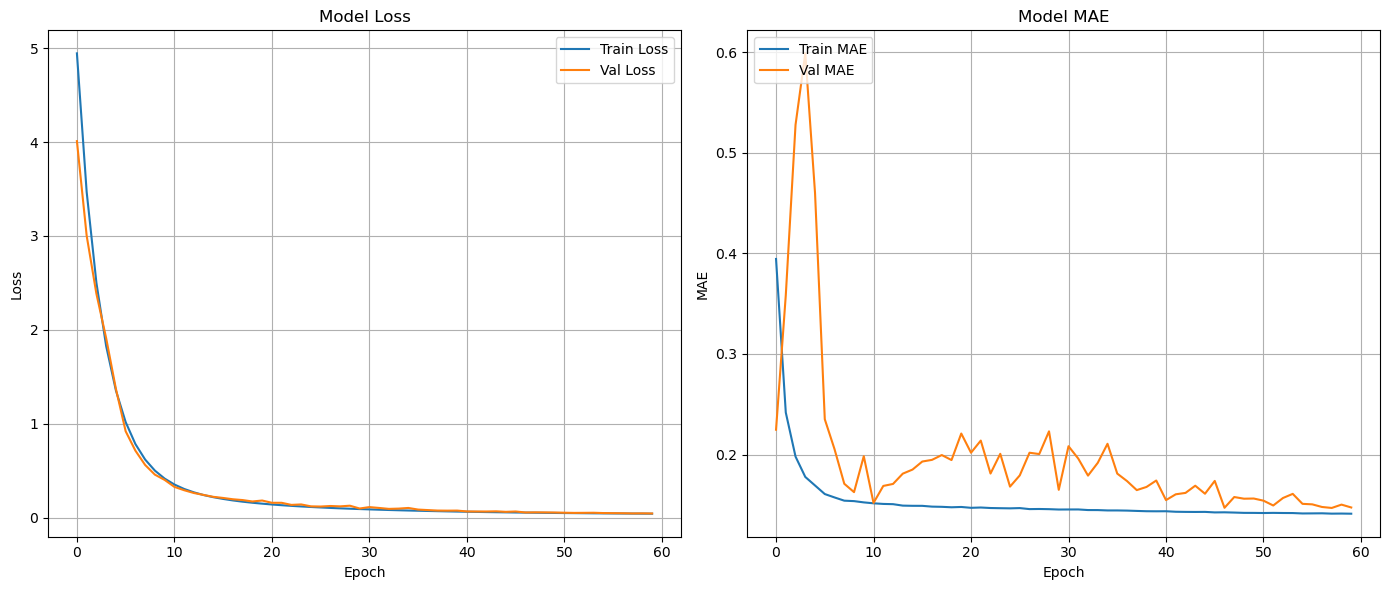

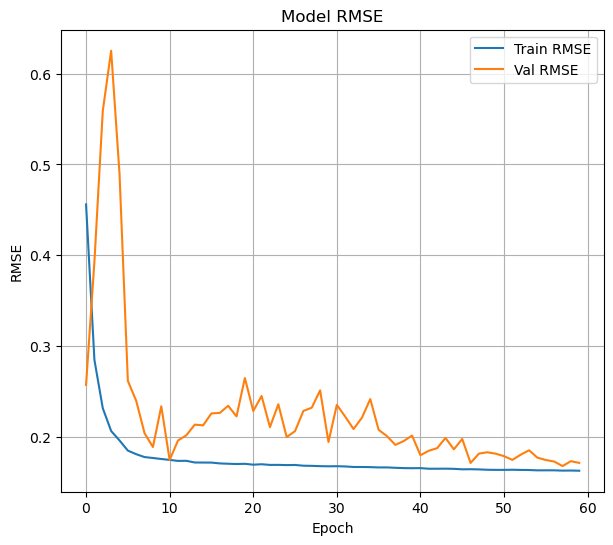

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

# MAE Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot training & validation RMSE
plt.figure(figsize=(7, 6))

# RMSE Plot
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Val RMSE')
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()


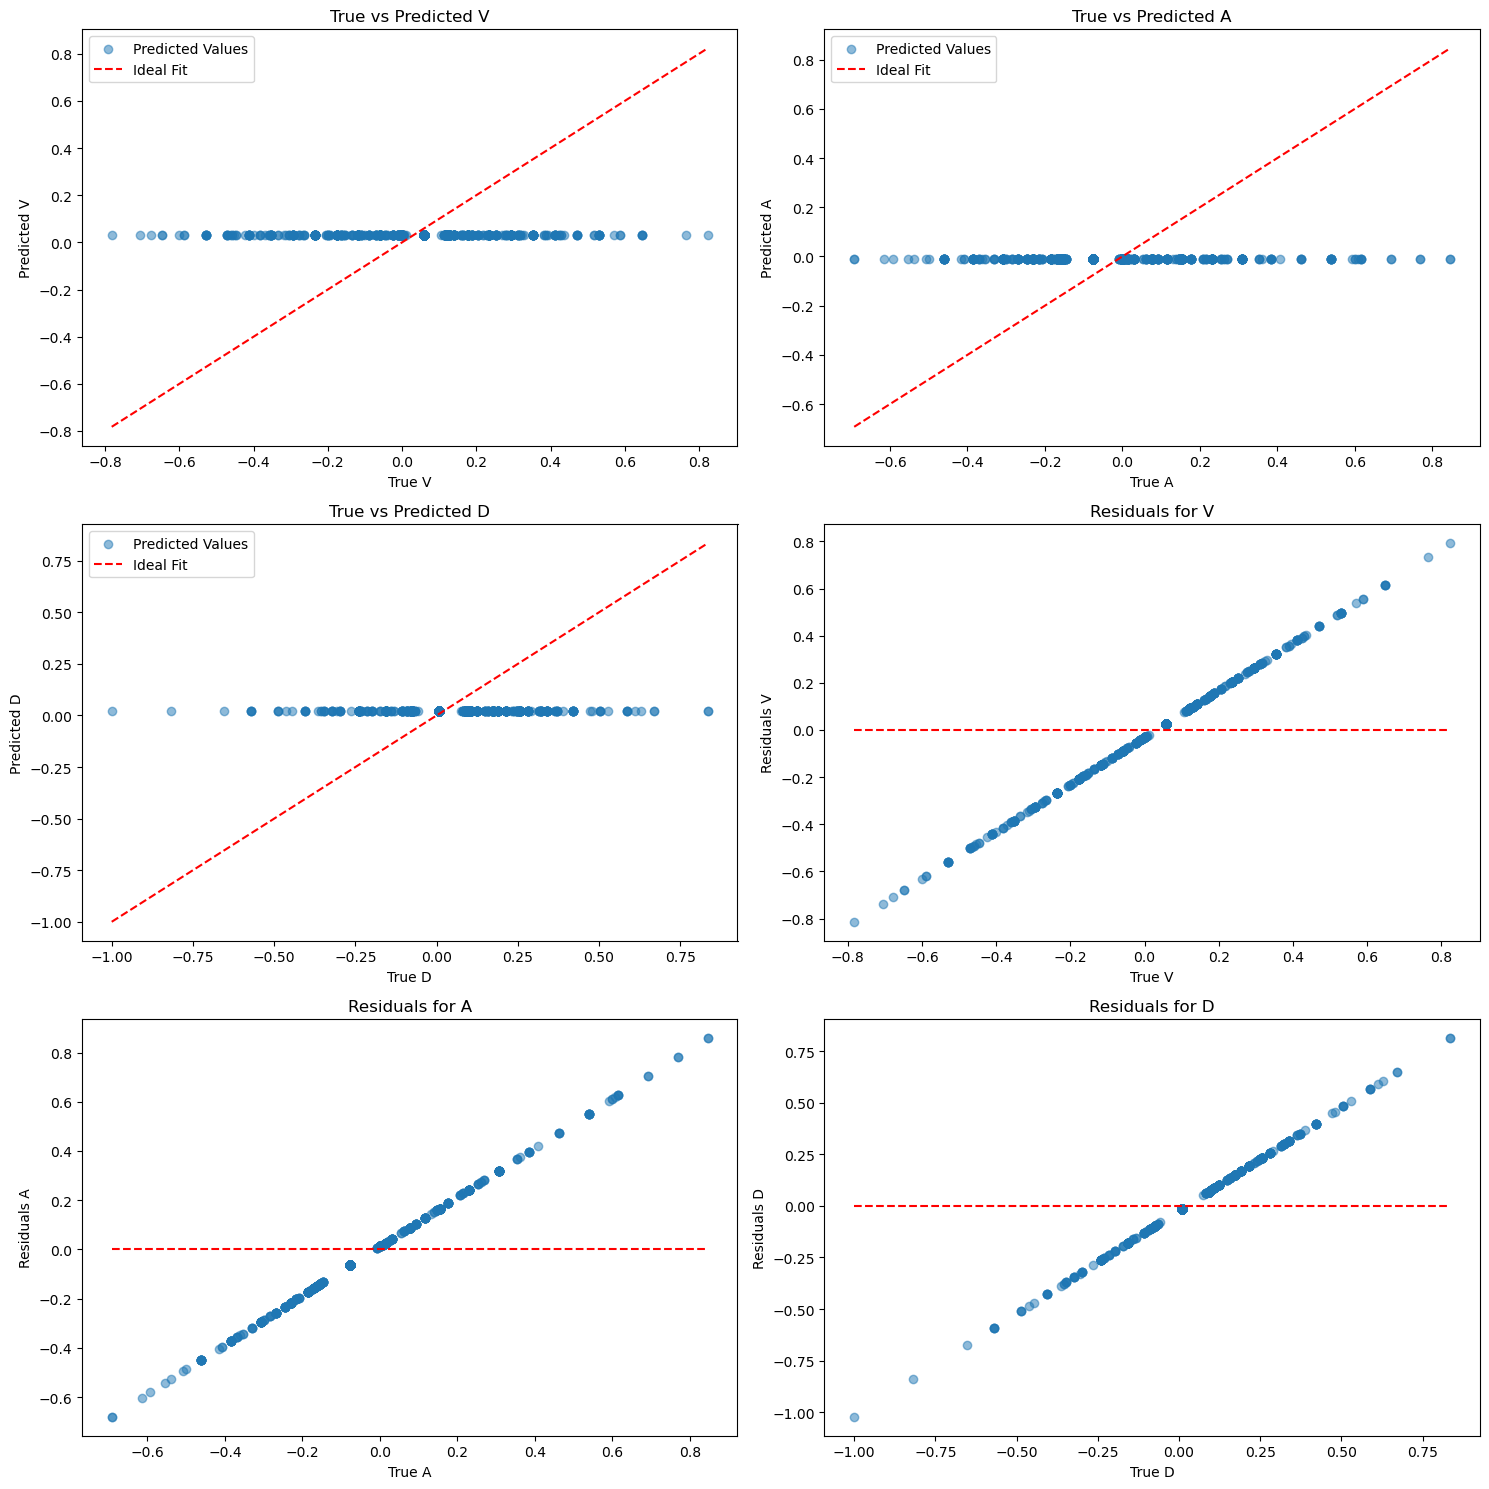

In [11]:
# Calculate residuals
residuals = y_test - y_test_pred

# Plot True Values vs Predictions
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()
targets = ["V", "A", "D"]

for i, target in enumerate(targets):
    # True vs Predicted Values
    axes[i].scatter(y_test[:, i], y_test_pred[:, i], alpha=0.5, label='Predicted Values')
    axes[i].plot([min(y_test[:, i]), max(y_test[:, i])], [min(y_test[:, i]), max(y_test[:, i])], 'r--', label='Ideal Fit')
    axes[i].set_xlabel(f'True {target}')
    axes[i].set_ylabel(f'Predicted {target}')
    axes[i].set_title(f'True vs Predicted {target}')
    axes[i].legend()

for i, target in enumerate(targets):
    # Residuals Plot
    axes[i + 3].scatter(y_test[:, i], residuals[:, i], alpha=0.5)
    axes[i + 3].hlines(0, min(y_test[:, i]), max(y_test[:, i]), colors='r', linestyles='dashed')
    axes[i + 3].set_xlabel(f'True {target}')
    axes[i + 3].set_ylabel(f'Residuals {target}')
    axes[i + 3].set_title(f'Residuals for {target}')

plt.tight_layout()
plt.show()

In [12]:
# Create DataFrames for each dataset and target variable
for i, target in enumerate(["V", "A", "D"]):
    df_train = pd.DataFrame({
        'Text': x_train.values,
        f'True_{target}': y_train[:, i],
        f'Predicted_{target}': y_train_pred[:, i]
    })
    df_val = pd.DataFrame({
        'Text': x_val.values,
        f'True_{target}': y_val[:, i],
        f'Predicted_{target}': y_val_pred[:, i]
    })
    df_test = pd.DataFrame({
        'Text': x_test.values,
        f'True_{target}': y_test[:, i],
        f'Predicted_{target}': y_test_pred[:, i]
    })


    print(f"\nSample DataFrame for train set, target variable {target}:")
    print(df_train.head())

    print(f"\nSample DataFrame for validation set, target variable {target}:")
    print(df_val.head())

    print(f"\nSample DataFrame for test set, target variable {target}:")
    print(df_test.head())


Sample DataFrame for train set, target variable V:
                                                Text    True_V  Predicted_V
0                                    asean talks end  0.058824     0.031547
1                 antibiotic ketek dangerous thought -0.235294     0.031546
2                  death throughout death everywhere -0.352941     0.031545
3  fascinating collection artifacts pertaining sh...  0.388235     0.031546
4  rat pack originally frank sinatra dean martin ...  0.058824     0.031545

Sample DataFrame for validation set, target variable V:
                                                Text        True_V  \
0                                   could free tasha  1.176471e-01   
1  differences western native perceptions lead co...  2.220446e-16   
2                 going shed little blood worry none  5.882353e-02   
3              simplicity dress seen mark modern man  1.235294e-01   
4                                          100 house  5.882353e-02   

   Predicted_V

In [13]:
# Save DataFrames to CSV files
df_train.to_csv(f'train_{target}_comparison_lstm_VAD_norm_Glove02.csv', index=False)
df_val.to_csv(f'val_{target}_comparison_lstm_VAD_norm_Glove02.csv', index=False)
df_test.to_csv(f'test_{target}_comparison_lstm_VAD_norm_Glove02.csv', index=False)